# Aggregated Heatmap of All Growth and Biochem Assay

Aggregate activity (and maybe tm) data into one plot and include key stats like percent id to wt, naturals, consensus
- ampicillin: [broth microdilution, colony counting, biochem]
- nitrocefin [Kcat, Km, Kcat/Km]
- Tm
- Mutation count from WT


In [1]:
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.colors import LogNorm

mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

## Constants

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/aggregated_heatmap'
if not os.path.exists(OUTPUT_DIR): os.mkdir(OUTPUT_DIR)

BROTH_MICRODILUTION_DATA_SHEETNAME = 'growth_broth_microdilution'
COLONY_DETCTION_DATA_SHEETNAME = 'growth_miccolony'
AMP_BIOCHEM_SHEETNAME = 'biochem_amp_specificactivity'
TM_SHEETNAME = 'melting_temperature_tm'
NITROCEFIN_SHEETNAME = 'biochem_nitrocefin_kinetics'
MICSTRIPS_DATA_SHEETNAME = 'growth_micstrips'

ANTIBIOITIC_CODE_NAME_HM = {
    'AMP': 'Ampicillin',
    'ATM': 'Aztreonam',
    'CAZ': 'Ceftazidime',
    'CFZ': 'Cefazolin',
    'INN': 'Cephalothin',
}

INFINITY = float('inf')
NEG_INFINITY = float('-inf')

In [3]:
OVERMAX_MULTIPLIER = 1.5
UNDERMIN_DIVIDER = 1.5
DATASETS_DF = pd.DataFrame.from_records([

    #
    #
    # Growth
    #
    #
    {'index': 'GROWTH_MICRODILUTION_AMP', 
     'label': 'Growth - Broth Microdilution MIC on Ampicillin',
     'vmin': 4, 'vmax': 4096, #one over max tested
     'log_scale': True},
    {'index': 'GROWTH_COLONY_AMP', 
     'label': 'Growth - Colony Formation MIC on Ampicillin',
     'vmin': 4.5, 'vmax': 2304, 'log_scale': True},
    {'index': 'GROWTH_MICSTRIPS_AMP', 
     'label': 'Growth - MIC Strips on Ampicillin',
     'vmin': 1, 'vmax': 256, #many over max tested
     'log_scale': True},

    {'index': 'GROWTH_MICRODILUTION_ATM', 
     'label': 'Growth - Broth Microdilution MIC on Aztreonam',
     'vmin': 0.06, 'vmax': 2, 'log_scale': True},
    {'index': 'GROWTH_MICSTRIPS_ATM', 
     'label': 'Growth - MIC Strips on Aztreonam',
     'vmin': 0.016, 'vmax': 1, 'log_scale': True},

    {'index': 'GROWTH_MICRODILUTION_CAZ', 
     'label': 'Growth - Broth Microdilution MIC on Ceftazidime',
     'vmin': 0.06, 'vmax': 2, 'log_scale': True},
    {'index': 'GROWTH_MICSTRIPS_CAZ', 
     'label': 'Growth - MIC Strips on Ceftazidime',
     'vmin': 0.037, 'vmax': 1, 'log_scale': True},

    {'index': 'GROWTH_MICRODILUTION_INN', 
     'label': 'Growth - Broth Microdilution MIC on Cephalothin',
     'vmin': 4, 'vmax': 256, #a few under min tested
     'log_scale': True},
    {'index': 'GROWTH_MICSTRIPS_INN', 
     'label': 'Growth - MIC Strips on Cephalothin',
     'vmin': 2, 'vmax': 256, #but many over max
     'log_scale': True},

    {'index': 'GROWTH_MICRODILUTION_CFZ',
     'label': 'Growth - Broth Microdilution MIC on Cefazolin',
     'vmin': 2, 'vmax': 64, #a couple over max tested
     'log_scale': True},

    #
    #
    # Biochemistry
    #
    #
    {'index': 'BIOCHEM_AMP', 
     'label': 'Biochemistry - Specific Activity on Ampicillin',
     'vmin': 0, 'vmax': 1400, 'log_scale': False,
     'na_samples': ['50.a', '50.b'], 'colors': 'Greens'},
    {'index': 'BIOCHEM_NITROCEFIN_KCAT_OVER_KM', 
     'label': 'Biochemistry - kcat/Km on Nitrocefin',
     'vmin': 0, 'vmax': 300, 'log_scale': False,
     'na_samples': ['50.a', '50.b'], 
     'nh_samples': ['neg. ctrl', 'rw-consensus', '70.b'],
     'colors': 'Greens'},
    #{'index': 'BIOCHEM_NITROCEFIN_KM', 
    # 'label': 'Biochemistry - Km on Nitrocefin',
    # 'vmin': 0, 'vmax': 400, 'log_scale': False
    # 'na_samples': ['50.a', '50.b'], 
    # 'nh_samples': ['neg. ctrl', 'rw-consensus', '70.b']},
    # 'colors': 'Reds'},
    #{'index': 'BIOCHEM_NITROCEFIN_KCAT', 
    # 'label': 'Biochemistry - kcat on Nitrocefin',
    # 'vmin': 0, 'vmax': 4500, 'log_scale': False
    # 'na_samples': ['50.a', '50.b'], 
    # 'nh_samples': ['neg. ctrl', 'rw-consensus', '70.b'],
    # 'colors': 'Reds'},

    #
    #
    # Thermostability
    #
    #
    {'index': 'TM', 
     'label': 'Thermostability - Change in Tm from WT TEM-1',
     'vmin': 0, 'vmax': 30, 'log_scale': False,
     'na_samples': ['50.a', '50.b'],
     'colors': 'Reds'},

    #{'index': 'MUT_WT', 
    # 'label': 'Mutation Count to WT TEM-1',
    # 'vmin': 0, 'vmax': 160}
]).set_index(
    'index'
).assign(
    #add empty lists for those datasets that had no na or nh samples
    na_samples = lambda x: x.na_samples.apply(
        lambda na: na if isinstance(na, list) else []
    ),
    nh_samples = lambda x: x.nh_samples.apply(
        lambda nh: nh if isinstance(nh, list) else []
    ),
    colors = lambda x: x.colors.apply(
        lambda col: col if isinstance(col, str) else 'Blues'
    ),
)

In [4]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

### Data Loading Functions

In [5]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################
#
# Load datasets into a standard dataframe. Rows represent
# replicates, but also include an aggregated value for all
# the replicates of a particular sample/design. The column
# names are standardized for each dataset for easy plotting:
#    manuscript_name (e.g., design or sample name as used in the manuscript)
#    agg_value (a single aggregated value for the sample)
#    rep_num (a single aggregated value for the sample)
#    rep_value
#    dataset
#    beta_lactam

def reorder_reindex_df(df):
    '''
    helper function to just pull out relevant columns in correct order
    and reset the index
    '''
    return df[[
        'manuscript_name', 'agg_value', 
        'rep_num', 'rep_value', 
        'dataset', 'beta_lactam'
    ]].reset_index(drop=True)

#############################
#                           #
#                           #
#   LOAD NITROCEFIN DATA    #
#                           #
#                           #
#############################
def load_biochem_nitrocefin_data():
    
    all_df = pd.read_excel(
        FHS.get_data_filename(), 
        sheet_name=NITROCEFIN_SHEETNAME
    )

    def load_df_of_param(param='kcat_over_Km'):
        '''
        load kcat, Km or kcat_over_Km into dataframe, calculating 
        the mean of replicates and removing extraneous columns
        '''
        dataset_name = 'BIOCHEM_NITROCEFIN_{0}'.format(param.upper())
        if dataset_name not in DATASETS_DF.index:
            return pd.DataFrame({})

        tmp_df = all_df[[
            'manuscript_name', 'rep_num', param
        ]].rename(
            columns={param: 'rep_value'}
        )

        tmp_df['agg_value'] = tmp_df.apply(
            lambda row: np.mean(
                tmp_df[tmp_df.manuscript_name==row.manuscript_name]['rep_value']
            ), axis='columns'
        )

        #replace infinity with nan - these are values that had no hydrolysis
        tmp_df.loc[tmp_df['agg_value'] == INFINITY, 'agg_value'] = np.nan
        tmp_df.loc[tmp_df['rep_value'] == INFINITY, 'rep_value'] = np.nan

        #add 50's even though they aren't present - will blank out later
        tmp_df = pd.concat([
            tmp_df,
            pd.DataFrame({
                'manuscript_name': ['50.a', '50.a', '50.a','50.b', '50.b', '50.b',],
                'rep_num': [1, 2, 3, 1, 2, 3],
                'agg_value': [np.nan for i in range(6)], 
                'rep_value': [np.nan for i in range(6)]
            })
        ])
        tmp_df['dataset'] = DATASETS_DF.loc[dataset_name].label
        tmp_df['beta_lactam'] = 'nitrocefin'
        return tmp_df

    return pd.concat([
        load_df_of_param('kcat_over_Km'),
        load_df_of_param('kcat'),
        load_df_of_param('Km')
    ]).reset_index(drop=True)



#############################
#                           #
#                           #
#      LOAD TM DATA         #
#                           #
#                           #
#############################
def load_tm_data():
    toreturn = pd.read_excel(
        FHS.get_data_filename(), 
        sheet_name=TM_SHEETNAME
    )[0:45][['Protein', 'Tm D']]

    toreturn = FHS.add_manuscript_name_to_df(
        toreturn, synonym_column='Protein',
        new_column='manuscript_name'
    )[['manuscript_name', 'Tm D']]

    toreturn['rep_delta_wt'] = toreturn.apply(
        lambda row: row['Tm D'] - np.mean(
            toreturn[toreturn.manuscript_name=='WT TEM-1']['Tm D']
        ), axis='columns'
    )

    toreturn['sample_delta_wt'] = toreturn.apply(
        lambda row: np.mean(
            toreturn[toreturn.manuscript_name==row['manuscript_name']]['Tm D']
        ) - np.mean(
            toreturn[toreturn.manuscript_name=='WT TEM-1']['Tm D']
        ), axis='columns'
    )

    #add 50's even though they aren't there - will indicate in plot
    toreturn = pd.concat([
        toreturn, 
        pd.DataFrame({
            'manuscript_name': ['50.a', '50.a', '50.a','50.b', '50.b', '50.b'],
            'Tm D': [np.nan for i in range(6)],
            'rep_delta_wt': [np.nan for i in range(6)],
            'sample_delta_wt': [np.nan for i in range(6)]
        })
    ]).drop(
        'Tm D', 
        axis='columns'
    ).rename(
        columns={
            'rep_delta_wt': 'rep_value',
            'sample_delta_wt': 'agg_value'
        }
    )
    toreturn['dataset'] = DATASETS_DF.loc['TM'].label
    toreturn['beta_lactam'] = 'N/A'
    toreturn['rep_num'] = toreturn.groupby('manuscript_name').cumcount().add(1)
    return reorder_reindex_df(toreturn)


#############################
#                           #
#                           #
#      LOAD AMP DATA        #
#                           #
#                           #
#############################

def load_ampicillin_biochem_data():
    '''
    load in the ampicillin biochemistry
    '''
    toreturn = pd.read_excel(
        FHS.get_data_filename(), 
        sheet_name= AMP_BIOCHEM_SHEETNAME
    ).rename(
        columns={'specific_activity': 'rep_value'}
    )
    toreturn['agg_value'] = toreturn.apply(
        lambda row: np.mean(
            toreturn[toreturn.manuscript_name==row.manuscript_name].rep_value
        ),
        axis='columns'
    )

    #add 50's even though they aren't present - will blank out later
    toreturn = pd.concat([
        toreturn,
        pd.DataFrame({
            'manuscript_name': ['50.a', '50.a', '50.a','50.b', '50.b', '50.b',],
            'rep_num': [1, 2, 3, 1, 2, 3],
            'agg_value': [np.nan for i in range(6)], 
            'rep_value': [np.nan for i in range(6)]
        })
    ])
    toreturn['dataset'] = DATASETS_DF.loc['BIOCHEM_AMP'].label
    toreturn['beta_lactam'] = 'ampicillin'
    return reorder_reindex_df(toreturn)


def load_ampicillin_growth_colonycounting_data():
    '''
    load in the colony detection MIC growth data
    '''
    toreturn = FHS.add_manuscript_name_to_df(
        pd.read_excel(
            FHS.get_data_filename(), 
            sheet_name=COLONY_DETCTION_DATA_SHEETNAME
        ), 
        synonym_column='Sample ID',
        new_column='manuscript_name'
    )
    toreturn = toreturn[toreturn['Sample ID'] != 'Untransformed DH5a'] #remove zeocin control
    toreturn['agg_value'] = toreturn.apply(
        lambda row: np.mean([row['Rep 1 MIC'], row['Rep 2 MIC'], row['Rep 3 MIC']]),
        axis=1
    )
    toreturn = toreturn[[
        'manuscript_name', 'Rep 1 MIC', 'Rep 2 MIC', 'Rep 3 MIC', 'agg_value'
    ]]
    toreturn = pd.melt(
        toreturn, id_vars=['manuscript_name', 'agg_value'], 
    ).reset_index(drop=True).rename(
        columns={
            'variable': 'rep_num',
            'value':'rep_value'
        }
    )
    toreturn.rep_num = toreturn.rep_num.apply(
        lambda rep_str: int(rep_str[4])
    )
    toreturn['beta_lactam'] = 'ampicillin'
    toreturn['dataset'] = DATASETS_DF.loc['GROWTH_COLONY_AMP'].label
    return reorder_reindex_df(toreturn)


#############################
#                           #
#                           #
#     LOAD BROTH DATA       #
#                           #
#                           #
#############################
def load_growth_broth_data():
    '''
    load in the broth microdilution data.
    values over max are set to infinity (inf) and values
    under min are set to minus infinity (-inf)
    '''
    orig_df = pd.read_excel(
        FHS.get_data_filename(), 
        sheet_name=BROTH_MICRODILUTION_DATA_SHEETNAME
    )

    #correct sample names
    orig_df = FHS.add_manuscript_name_to_df(
        orig_df, synonym_column='sample_id', new_column='manuscript_name'
    )

    #fix the greater than / less than min max values for plotting
    def check_min_max(val):
        try:
            return float(val)
        except ValueError as e:
            if val[0] == '>': return INFINITY
            if val[0] == '≤': return NEG_INFINITY
            if val == 'Invalid': return np.nan
            raise e


    for antibiotic in ANTIBIOITIC_CODE_NAME_HM.keys():
        orig_df[antibiotic] = orig_df[antibiotic].apply(
            lambda val: check_min_max(val)
        )
        orig_df['{0}_aggregated'.format(antibiotic)] = orig_df['{0} Result'.format(antibiotic)].apply(
            lambda val: check_min_max(val)
        )

    #Munge datafarme, selecting out a particular antibioitic, removing
    #the replicates that are not relevant per Kristen's algorithm
    def valid_replicate(row, antibiotic):
        '''
        evaluate whether a particular row is valid for a particular antibioitic
        '''
        if antibiotic == 'AMP' and \
           row.sample_id=='consensus' and \
           row['Rep # \n(matched rep #, 1-5)'] == 2: 
           #special case for the single invalid number in the spreadsheet
           return False

        if row['Repeat Testing Performed?']=='No': return True
        if row['Rep # \n(matched rep #, 1-5)'] <= 3: return True
        if antibiotic in row['Repeated Drug(s)']: return True
        return False

    toreturn_df = pd.DataFrame()
    for antibiotic in ANTIBIOITIC_CODE_NAME_HM.keys():
        antibiotic_df = orig_df[
            orig_df.apply(lambda row: valid_replicate(row, antibiotic), axis=1)
        ]
        antibiotic_df = antibiotic_df[[
            'manuscript_name', 'Rep # \n(matched rep #, 1-5)', 
            antibiotic, '{0}_aggregated'.format(antibiotic),
        ]].rename(
            columns = {
                'Rep # \n(matched rep #, 1-5)': 'rep_num',
                antibiotic: 'rep_value',
                '{0}_aggregated'.format(antibiotic): 'agg_value',
            }
        )
        antibiotic_df['beta_lactam'] = ANTIBIOITIC_CODE_NAME_HM[antibiotic]
        antibiotic_df['dataset'] = DATASETS_DF.loc[
            'GROWTH_MICRODILUTION_{0}'.format(antibiotic)
        ].label
        toreturn_df = pd.concat([toreturn_df, antibiotic_df])
    return reorder_reindex_df(toreturn_df)


#############################
#                           #
#                           #
#    LOAD MICSTRIP DATA     #
#                           #
#                           #
#############################
def load_micstrip_data():
    '''
    load the mic strip data
    '''
    excel_full_df = pd.read_excel(FHS.get_data_filename(), 
                                  sheet_name=MICSTRIPS_DATA_SHEETNAME).melt(
        id_vars=['sample_id', 'antibiotic'], 
        value_vars=['rep_1', 'rep_2', 'rep_3'],
    )
    
    #correct sample names
    excel_full_df = FHS.add_manuscript_name_to_df(
        excel_full_df, synonym_column='sample_id', new_column='manuscript_name'
    ).rename(
        {'variable': 'rep_num', 'value': 'rep_value'}, 
        axis='columns'
    )

    #drop the rep_ string and set as int
    excel_full_df.rep_num = excel_full_df.rep_num.apply(
        lambda rep: int(rep[-1])
    )

    #replace 'max' with inf
    excel_full_df.loc[
        excel_full_df['rep_value'] == 'max', 
        'rep_value'
    ] = INFINITY

    toreturn_df = pd.DataFrame()
    for antibiotic in ['AMP', 'ATM', 'CAZ', 'INN']:
        antibiotic_df = excel_full_df[
            excel_full_df.antibiotic == ANTIBIOITIC_CODE_NAME_HM[antibiotic]
        ].reset_index(drop=True)

        def aggregate_micstrip_values(sample_name):
            rep_vals = list(
                antibiotic_df[
                    antibiotic_df.manuscript_name==sample_name
                ].rep_value
            )

            if ANTIBIOITIC_CODE_NAME_HM[antibiotic] == 'Cephalothin':
                #is there a mode? if so, return it
                if rep_vals[0] == rep_vals[1]: return rep_vals[0]
                if rep_vals[0] == rep_vals[2]: return rep_vals[0]
                if rep_vals[1] == rep_vals[2]: return rep_vals[1]
                
                #no mode so return the median
                return np.median(rep_vals)
            return np.mean(rep_vals)
        
        antibiotic_df['agg_value'] = antibiotic_df.manuscript_name.apply(
            aggregate_micstrip_values
        )

        antibiotic_df['beta_lactam'] = ANTIBIOITIC_CODE_NAME_HM[antibiotic]
        antibiotic_df['dataset'] = DATASETS_DF.loc[
            'GROWTH_MICSTRIPS_{0}'.format(antibiotic)
        ].label
        toreturn_df = pd.concat([toreturn_df, antibiotic_df])

    return toreturn_df[[
        'manuscript_name', 'agg_value', 
        'rep_num', 
        'rep_value', 'dataset', 'beta_lactam'
    ]].sort_values([
        'dataset', 'manuscript_name', 'rep_num'
    ]).reset_index(drop=True)


### Load and aggregate each dataset

In [6]:
growth_colonycounting_df = load_ampicillin_growth_colonycounting_data()
growth_broth_df = load_growth_broth_data()
micstrip_df = load_micstrip_data()
biochem_amp_df = load_ampicillin_biochem_data()
tm_df = load_tm_data()
biochem_nitrocefin_df = load_biochem_nitrocefin_data()

In [7]:
all_data_df = pd.concat([
    growth_colonycounting_df,
    growth_broth_df,
    micstrip_df,
    biochem_amp_df,
    tm_df,
    biochem_nitrocefin_df,
])

#pbs not very informative and only in a couple assays
all_data_df = all_data_df[
    all_data_df.manuscript_name != 'pbs'
].reset_index(
    drop=True
)

#remove the individual replicate values
aggregated_df = all_data_df.drop(
    ['rep_num', 'rep_value'], 
    axis='columns'
).drop_duplicates().reset_index(drop=True)

#pivot the df so it is 2d
aggregated_pivoted_df = aggregated_df.pivot(
    index='dataset',
    columns='manuscript_name', 
    values='agg_value'
)[
    #easy way to sort the columns
    FHS.get_sample_order(aggregated_df.manuscript_name)
]

#reorder pivoted dataframe index to be the same order in DATASETS_DF
aggregated_pivoted_df = aggregated_pivoted_df.loc[DATASETS_DF.label]

## Plotting

In [8]:
def plot_heatmap(horizontal_cmap=False):
    fig, axes = plt.subplots(
        len(aggregated_pivoted_df), 1, 
        sharex=True,
        gridspec_kw={'hspace': 0.0} #remove height space
    )
    height = len(aggregated_pivoted_df)
    if horizontal_cmap: height = height * 2
    fig.set_size_inches(20, height)

    for idx in range(0, len(aggregated_pivoted_df)):
        label = aggregated_pivoted_df.iloc[idx].name
        dataset_props = DATASETS_DF[DATASETS_DF.label==label].iloc[0]
        ax = axes[idx]


        #replace those over max or under min with discrete values for the plotting
        noinf_df = aggregated_pivoted_df[
            aggregated_pivoted_df.index == label
        ].copy()
        
        #
        #
        # LABELS - smart rounding, then N/A, N/H, and the over min and under max
        #
        #
        na_indicies = [
            noinf_df.columns.get_loc(na_sample) for na_sample in dataset_props.na_samples
        ]
        nh_indicies = [
            noinf_df.columns.get_loc(nh_sample) for nh_sample in dataset_props.nh_samples
        ]
        def get_label(idx, val):
            if idx in na_indicies: return 'N/A'
            if idx in nh_indicies: return 'N/H'
            if val == NEG_INFINITY: return '≤{0:.0f}'.format(dataset_props.vmin)
            if val == INFINITY: return '>{0:.0f}'.format(dataset_props.vmax)
            if val % 1 == 0: return '{0:.0f}'.format(val)
            if val > 1: return '{0:.1f}'.format(val)
            if (val * 10) % 1== 0: return '{0:.1f}'.format(val)
            if (val * 100) % 1== 0: return '{0:.2f}'.format(val)
            return '{0:.3f}'.format(val)

        labels = [get_label(idx, x) for idx, x in enumerate(noinf_df.iloc[0])]

        #
        #
        #COLORS
        # - colors for infinity are max * 1.5
        # - colors for -infinity are min / 1.5
        # - colors for N/A and N/H are zero
        #
        noinf_df = noinf_df.where(
            noinf_df != INFINITY, dataset_props.vmax * OVERMAX_MULTIPLIER
        )
        noinf_df = noinf_df.where(
            noinf_df != NEG_INFINITY, dataset_props.vmin / UNDERMIN_DIVIDER
        )
        noinf_df.loc[:, dataset_props.na_samples] = 0
        noinf_df.loc[:, dataset_props.nh_samples] = 0
        
        #
        # prepare color normalization
        #
        norm = 'linear'
        if dataset_props.log_scale: 
            norm = LogNorm(vmin = np.min(noinf_df.iloc[0]), #dataset_props.vmin, 
                           vmax = np.max(noinf_df.iloc[0]))#dataset_props.vmax)
            
        #
        #
        # plot
        #
        #
        colors = sns.color_palette('Blues', as_cmap=True)
        cbar_kws = {}
        if horizontal_cmap:
            cbar_kws = {'orientation': 'horizontal'}

        sns.heatmap(
            data=noinf_df,
            annot = np.array([labels]),
            fmt='s', linewidth=.5, square=True,
            norm=norm, 
            vmin=np.min(noinf_df.iloc[0]), #only valid if norm='linear'
            vmax=np.max(noinf_df.iloc[0]), #only valid if norm='linear'
            cmap=sns.color_palette(
                dataset_props.colors, as_cmap=True
            ),
            cbar_kws=cbar_kws,
            ax=ax,
        )

        #
        #
        # Styling and labels
        #
        #
        if idx != len(aggregated_pivoted_df) - 1:
            ax.tick_params(bottom=False)
            ax.set_xlabel(None)
        else:
            ax.set_xlabel('Design')
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, 
                            ha='right', rotation_mode='anchor')
        ax.set_ylabel(None)
        ax.set_yticklabels(
            ax.get_ymajorticklabels(),
            rotation = 0,
            minor=False
        )
    figname = 'aggregated_heatmap.pdf'
    if horizontal_cmap:
        figname = 'aggregated_heatmap_horizontalcmap.pdf'
    fig.savefig(OUTPUT_DIR+'/'+figname)

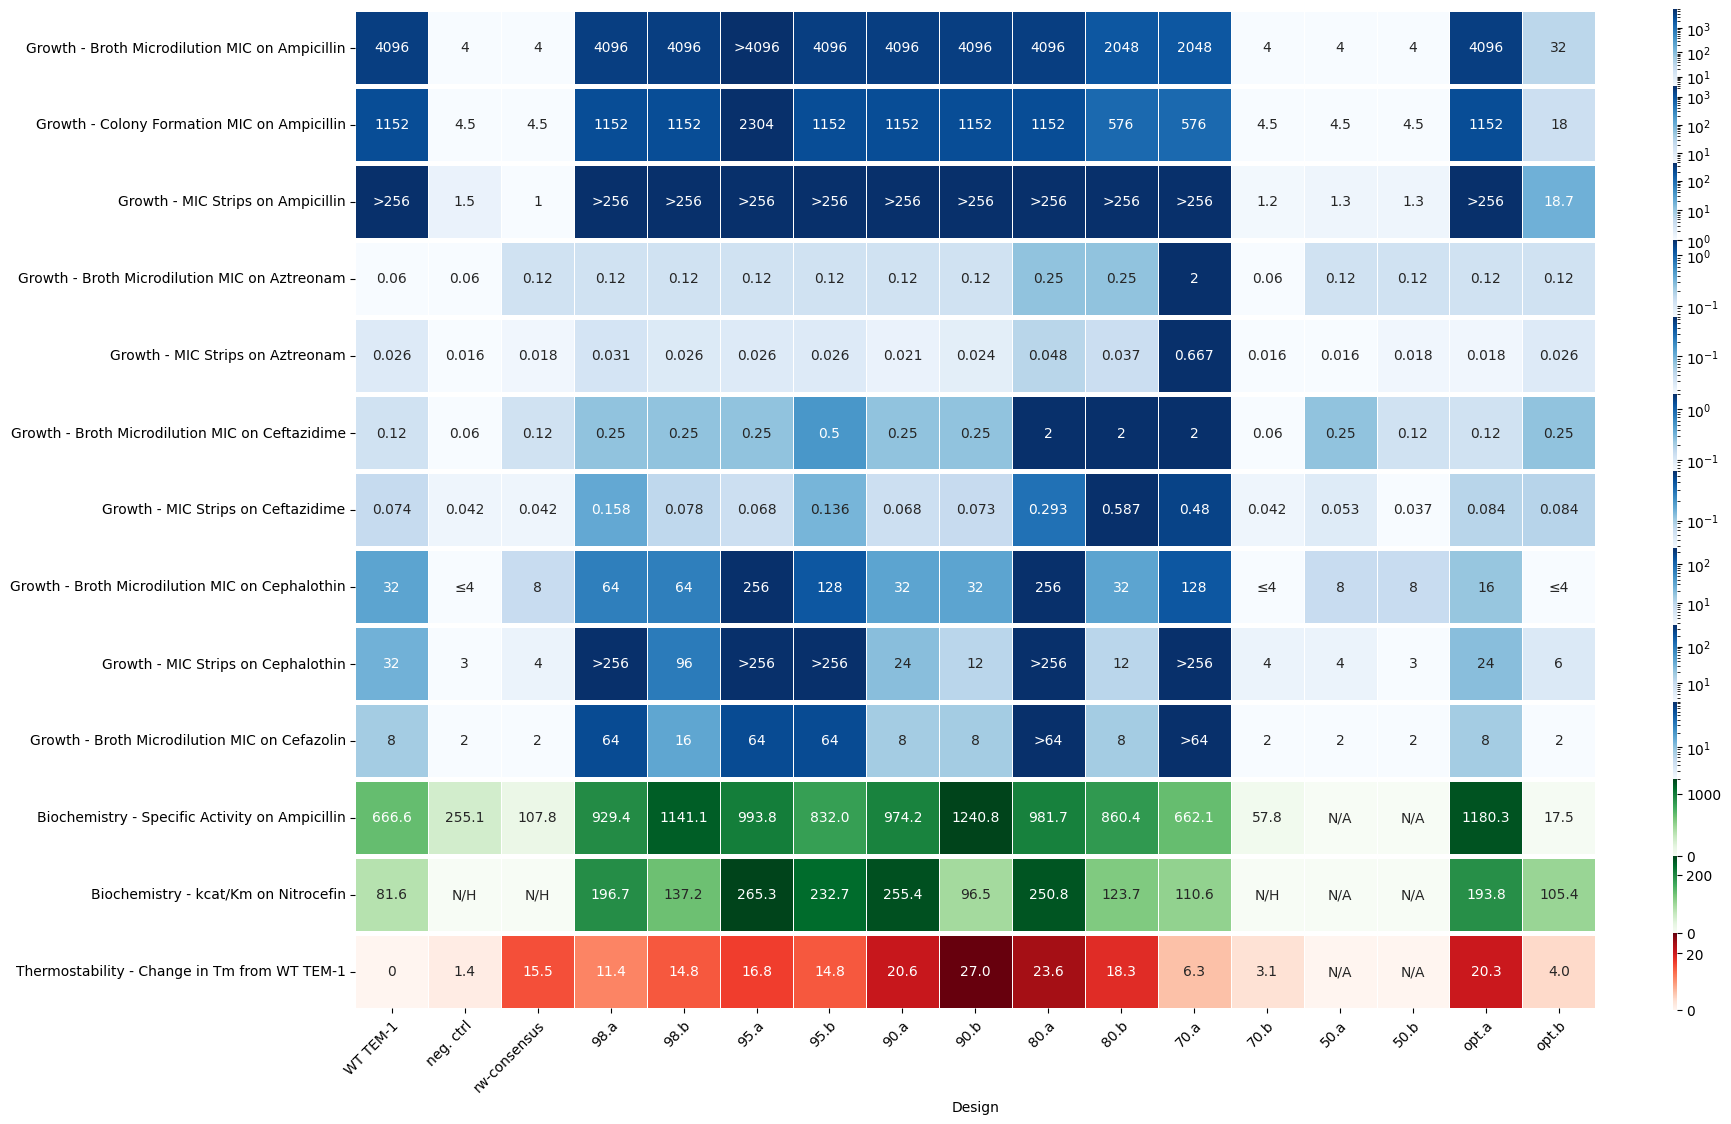

In [9]:
plot_heatmap()

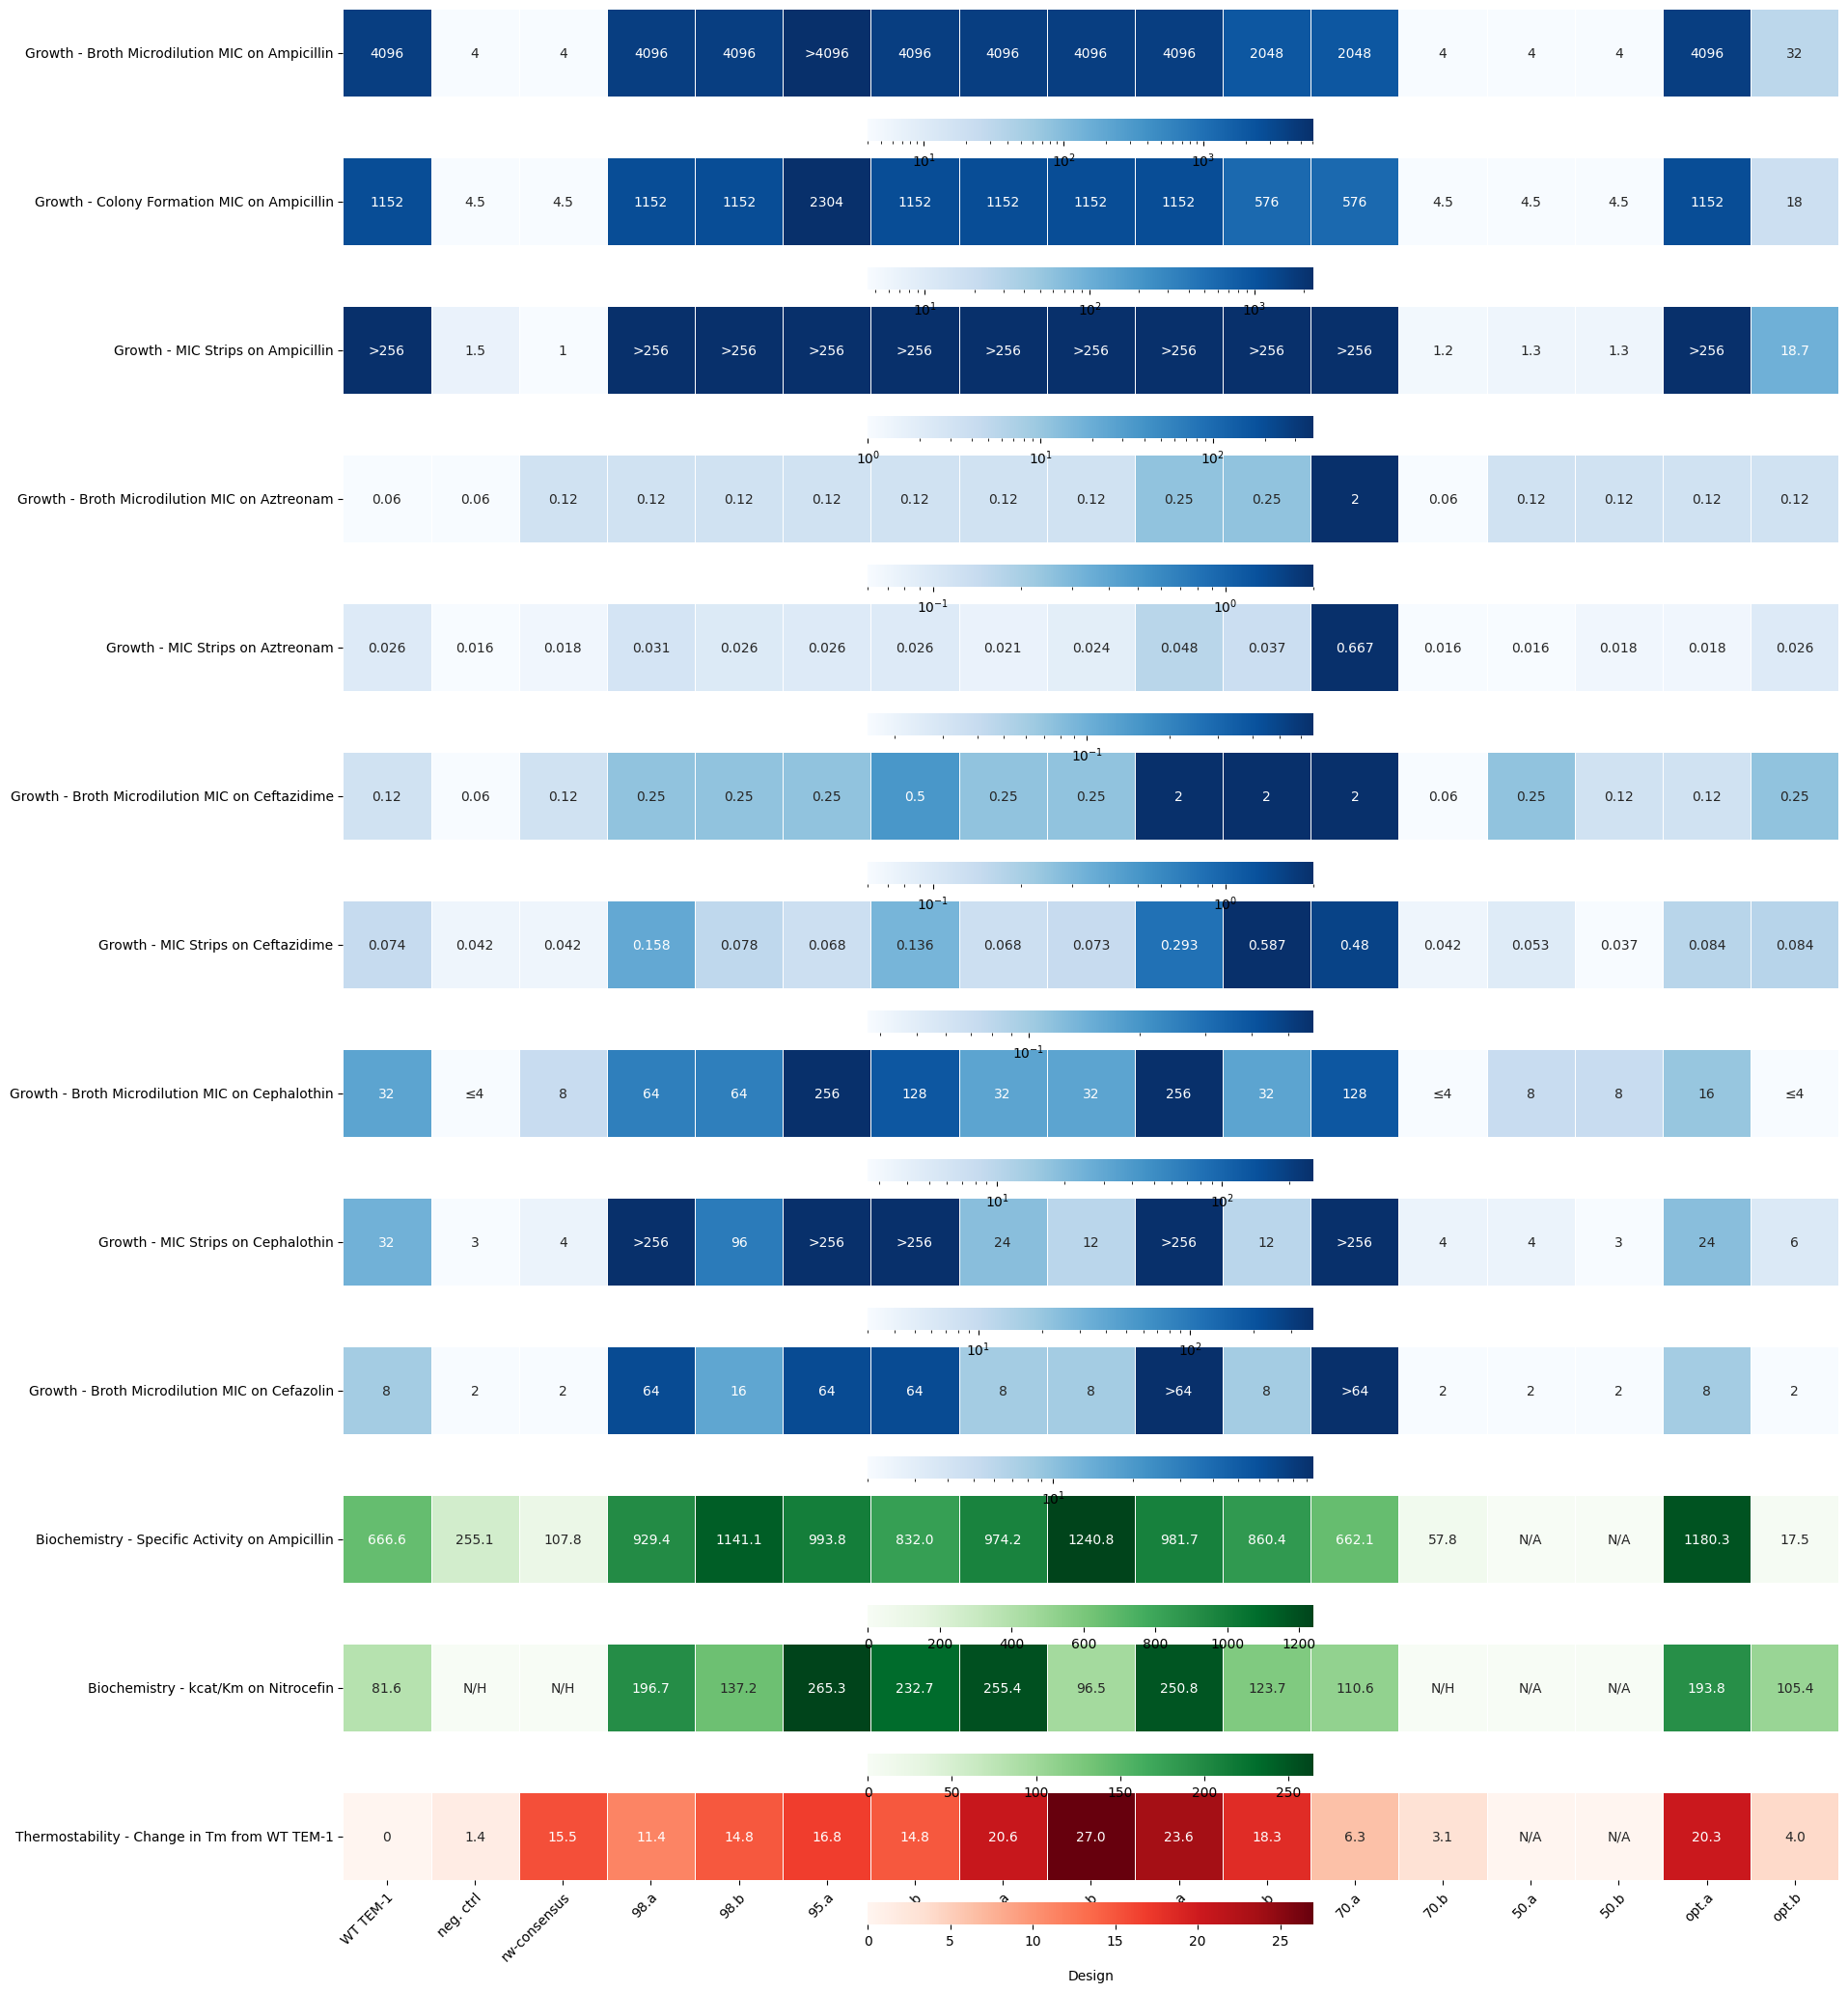

In [10]:
plot_heatmap(horizontal_cmap=True)